# ANN from Scratch
## ANN Base Class

In [1]:
# Import the numpy module
import numpy as np
# import the pandas module
import pandas as pd

In [2]:
class ANN:
    def __init__(self, numInputs, numHidden, numOutputs, lr=0.1, epoch=100, randomState=1234):
        np.random.seed(randomState)

        # We define the shape of our network. Each neuron in a layer is connected to all neurons in next layer. Since we have three layers, we need to specify the connections for the Input-Hidden and Hidden-Output layers
        architectureShape = list(
            zip([numInputs, numHidden], [numHidden, numOutputs]))

        # For the given shape of the network we generate random weights
        self.weights = [np.random.randn(m, n) for m, n in architectureShape]
        # Random bias values are set for each neuron rather than each connection
        self.bias = [np.zeros(n) for _, n in architectureShape]

        # Set the learning rate
        self.lr = lr

        # Set the number of epoch
        self.epoch = epoch
    
    # A sigmoid activation function. A second argument "derive" when True calculates the derivative
    def sigmoid(self, x, derive=False):
        if derive:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    # Given the features, weights and biases, perform as forward pass and returns the output from each layer: Input-Hidden, Hidden-Output
    def forward(self, X):

        # Input -> Hidden
        layer1Input = X.dot(self.weights[0]) + self.bias[0]
        layer1Output = self.sigmoid(layer1Input)

        # Hidden -> Output
        layer2Input = layer1Output.dot(self.weights[1]) + self.bias[1]
        layer2Output = self.sigmoid(layer2Input)

        return layer1Output, layer2Output
    
    # Given the outputs of each layer, performs backward pass calculating the error and recommended change for the weights and bias
    def backward(self, layer1Output, layer2Output, y):
        # Output -> Hidden
        layer2Error = y - layer2Output
        layer2Delta = layer2Error * self.sigmoid(layer2Output, derive=True)

        # Hidden -> Input
        # Layer 1 weights transposed is supplied as the parameter
        layer1Error = layer2Delta.dot(self.weights[1].T)
        layer1Delta = layer1Error * self.sigmoid(layer1Output, derive=True)

        return layer2Error, layer1Error, layer1Delta, layer2Delta
    
    # Given the input features, and the outputs from forward pass at each layer and recommended change measured through backward pass, updates the weights and biases
    def updateWeightsBias(self, X, layer1Output, layer1Delta, layer2Delta):
        # Hidden -> Output
        self.weights[1] += self.lr * layer1Output.T.dot(layer2Delta)

        for d in layer2Delta:
            self.bias[1] += self.lr * d

        # Input -> Hidden
        self.weights[0] += self.lr * X.T.dot(layer1Delta)

        for d in layer1Delta:
            self.bias[0] += self.lr * d

    # Abstract function
    # Given the features and a trained set of weights and biases, predicts the labels/classes
    def predict(self, X):
        pass

    # Abstract function
    # Measures the accuracy of the prediction
    def accuracy(self, actual, predicted):
        pass

    # Trains the weights and biases. Accepts the features, labels/classes, random weights and bias as inputs. Additionally a learning rate and epoch argument can be tweeked to improve the performance
    def train(self,features, labels):
        # Trains on the complete train data set multiple times. Determined by the value specified for epoch
        for e in range(self.epoch):
            # Performs a forward pass
            layer1Output, layer2Output = self.forward(features)
            # Performs a backward pass
            layer2Error, layer1Error, layer1Delta, layer2Delta = self.backward(
                layer1Output, layer2Output, labels)
            # Updates the weights and biases
            self.updateWeightsBias(
                features, layer1Output, layer1Delta, layer2Delta)
            # Print the stats at regular intervals
            if(e % 100 == 0 or e == self.epoch-1):
                # Measure the error
                trainError = np.mean(np.abs(layer2Error))
                print("epoch {:0} ".format(e), end='|')
                print('error:{:0.4f} '.format(trainError), end='|')

                # Perform prediction on the train dataset itself, to understand how well it is able to learn from it
                predictions = self.predict(features)
                # Calculate the accuracy of the predictions
                trainAccuracy = self.accuracy(labels, predictions)
                print(" accuracy {:0.2f} ".format(trainAccuracy)) 
           


## ANN Classification Specialization

In [3]:
class ANNClassification(ANN):      

    # Given the features and a trained set of weights and biases, predicts the labels/classes
    def predict(self, X):
        # Performs a forward pass with the trained weights and bias and uses the Hidden-Output layer output as prediction
        _, layer2Output = self.forward(X)
        return layer2Output
    # Measures the accuracy of the prediction
    def accuracy(self, actual, predicted):
        actual = np.argmax(actual, axis=1)
        predicted = np.argmax(predicted, axis=1)

        return np.sum(predicted == actual) / len(actual)
    


## Classification Example
- Training and testing our model with a hand written digits dataset
    - The data set is acquired from the <a src="https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits"> UCI machine learning repository</a>. 
    - The relevant files are organized inside the associated **./data** folder
      - optdigits.names: file provides some general description about the data set. Read it to understand more about the data.
      - optdigits.tra: is the training data set, that we will use to train our model
      - optdigits.tes: is the test data set, that we will use to test our model
      - Each row in the test and train data files is a hand written digit and a numeric value stating the digit in the image
        - its  contains 65 comma seperated values.
        - the first 64 values contains the pixel information for the image. **We call this as features**
        - the last value is the numeric value of the hand written digit. **We call this as a label/class**
    - The train features, test features, train labels and test labels should be stored into 4 ndarrays respectively
    - Since its a classification problem, the train and test labels should be stored as an ndarray 
      - with the size for axis=0 as the total number of labels in the dataset 
      - size for axis=1 as the number of unique labels
      - since the numeric labels are between 0 - 9, we want to assign a value of 1 to the index on axis=1 that represents the  numeric value. The remaining indices for axis=1 should be zero

### Loading the data

In [14]:
# install the csv module, if not available. We need it to load our dataset
import csv

# Loading the training dataset
with open('./data/optdigits.tra') as f:
    # reading the CSV file
    csvFile = csv.reader(f)
    blob = [l for l in csvFile]


### Prepping the Data
#### Training Set

In [5]:
# Based on the data set description, store the features or data about the image into an ndarray. Note data about a hand written image is flatted and each index for axis=0 contains information about a single hand written image
features = np.array([r[:-1] for r in blob], dtype=float)
# Based on the data set description, store the labels in another ndarray. Note that the labels are an integer value between 0 - 9 that state the digit represented in the handwritten image
_labels = np.array([r[-1] for r in blob], dtype=float)

# We want to represent the lables in a way so that they can be used for classification.
uniqueLabels = np.unique(_labels)
uniqueLabels.sort()
# We create an new ndarray wit the size for axis=0 as the number of labels in the dataset and size for axis=1 as the number of unique labels.
labels = np.zeros((len(_labels), len(uniqueLabels))) * 1.0

# Since the labels are between 0 - 9, we want to assign a value of 1 to the index on axis=1 that represents the label digit value
for i, l in enumerate(_labels):
    labels[i, int(l)] = 1.0


In [6]:
# Install the matplotlib module if not available.
# Import the module matplotlib.pyplot
import matplotlib.pyplot as plt

# Let us create a function, to display the feature


def draw(ax, feature, actualLabel, predictedLabel="-"):
    # Since there are 8x8 pixels stored as a flatted array, we reshape it to 8x8 in order to display it
    ax.matshow(feature.reshape(8, 8))
    ax.set_title("actual:{0}, predicted:{1}".format(
        actualLabel, predictedLabel))


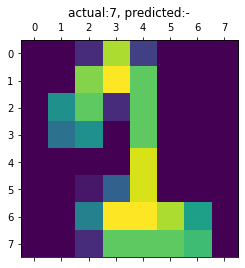

In [7]:
# We draw a feature to see how it looks
fig, axs = plt.subplots(1, 1)
draw(axs, features[99], np.argmax(labels[2]))


#### Test Set

In [8]:
# Loading the training dataset
with open('./data/optdigits.tes') as f:
    # reading the CSV file
    csvFile = csv.reader(f)
    blob = [l for l in csvFile]

# Store the test feature into a variable
testFeatures = np.array([r[:-1] for r in blob], dtype=float)

# Process and store the test labels in proper format, like done for the train dataset
_labels = np.array([r[-1] for r in blob], dtype=float)
uniqueLabels = np.unique(_labels)
uniqueLabels.sort()
testLabels = np.zeros((len(_labels), len(uniqueLabels))) * 1.0

for i, l in enumerate(_labels):
    testLabels[i, int(l)] = 1.0


### Creating the model

In [9]:
# Let us now use our ANN
# We specify the number of neurons for the input layer as the number of features
numInputs = features.shape[1]
# We arbitrarily choose the number of hidden neurons. Seeing if changing this it improves or degrades the performance
numHidden = 20
# Since there are 10 labels 0 - 9, we have 10 neuron in the output layer
numOutputs = 10
# The number of times we want to train our model on the complete dataset
epoch = 1200  # Seeing if changing this it improves or degrades the performance

# Set the learning rate
lr = 0.001

# Set the random seed
randomState = 1234

print("number of input nodes:{0}, hidden nodes:{1} and output nodes:{2}".format(
    numInputs, numHidden, numOutputs))


number of input nodes:64, hidden nodes:20 and output nodes:10


In [10]:
# Initialize the model
annClassifier = ANNClassification(
    numInputs, numHidden, numOutputs, lr, epoch, randomState)


#### Training

In [11]:
# Train the model. See if changing the lr (learning rate) it improves or degrades the performance
annClassifier.train(features, labels)


epoch 0 |error:0.5149 | accuracy 0.10 
epoch 100 |error:0.1332 | accuracy 0.63 
epoch 200 |error:0.0978 | accuracy 0.78 
epoch 300 |error:0.0747 | accuracy 0.82 
epoch 400 |error:0.0628 | accuracy 0.84 
epoch 500 |error:0.0557 | accuracy 0.84 
epoch 600 |error:0.0508 | accuracy 0.85 
epoch 700 |error:0.0474 | accuracy 0.85 
epoch 800 |error:0.0453 | accuracy 0.86 
epoch 900 |error:0.0457 | accuracy 0.86 
epoch 1000 |error:0.0452 | accuracy 0.95 
epoch 1100 |error:0.0395 | accuracy 0.95 
epoch 1199 |error:0.0357 | accuracy 0.96 


#### Testing

In [12]:
# Since we already have a trained model, we do not need to train it again with the test dataset
# Instead, we can perdict the test labels, but only providing the test features
predicted = annClassifier.predict(testFeatures)
print('accuracy', annClassifier.accuracy(testLabels, predicted))


accuracy 0.9065108514190318


### Visualizing the Result

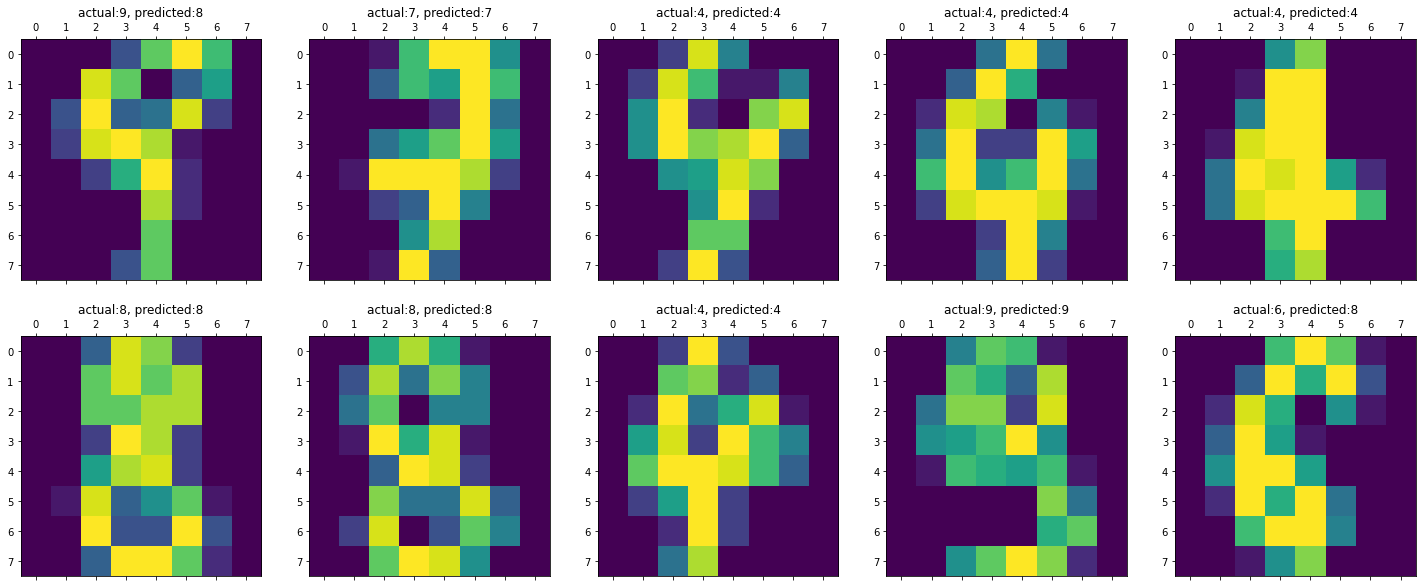

In [13]:
# Randomly showing 10 test images
indices = np.random.randint(0, len(predicted), size=10)
fig, axs = plt.subplots(2, 5, figsize=(25, 10))

ai = 0
aj = 0
for i in indices:

    draw(axs[ai, aj], testFeatures[i], np.argmax(
        testLabels[i]), np.argmax(predicted[i]))
    aj += 1
    if aj % axs.shape[1] == 0:
        ai += 1
        aj = 0
